In [1]:
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_selection import SelectPercentile, chi2

np.random.seed(0)

In [3]:
X, y = fetch_openml(
    "titanic", version=1, as_frame=True, return_X_y=True, parser="pandas"
)

# Alternatively X and y can be obtained directly from the frame attribute:
# X = titanic.frame.drop('survived', axis=1)
# y = titanic.frame['survived']

In [7]:
display(X)

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,"Zabour, Miss. Hileni",female,14.5000,1,0,2665,14.4542,NaN,C,NaN,328.0,NaN
1305,3,"Zabour, Miss. Thamine",female,NaN,1,0,2665,14.4542,NaN,C,NaN,NaN,NaN
1306,3,"Zakarian, Mr. Mapriededer",male,26.5000,0,0,2656,7.2250,NaN,C,NaN,304.0,NaN
1307,3,"Zakarian, Mr. Ortin",male,27.0000,0,0,2670,7.2250,NaN,C,NaN,NaN,NaN


In [8]:
X.dtypes

pclass          int64
name           object
sex          category
age           float64
sibsp           int64
parch           int64
ticket         object
fare          float64
cabin          object
embarked     category
boat           object
body          float64
home.dest      object
dtype: object

In [9]:
categorical_cols = [feature for feature in X.columns if X[feature].dtype == 'O']
numerical_cols = [feature for feature in X.columns if X[feature].dtype != 'O']

In [10]:
numerical_cols

['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'body']

In [11]:
categorical_cols

['name', 'ticket', 'cabin', 'boat', 'home.dest']

In [17]:
from collections import Counter
print(Counter(X['pclass']))

Counter({3: 709, 1: 323, 2: 277})


In [19]:
numeric_features = ["age", "fare"]
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_features = ["embarked", "sex", "pclass"]
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ("selector", SelectPercentile(chi2, percentile=50)),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [20]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.798


In [21]:
clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('selector',
                                                                   SelectPercentile(percentile=50,
                                                                                    score_func=<function chi2 at 0x0000016F42538CA0>))]),
                                                  ['embarked', 'sex',
                                                   'pclass'])])),
                ('classifier', LogisticRegression())])

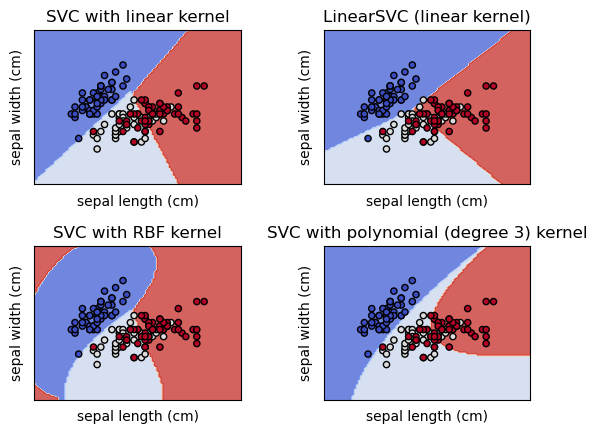

In [1]:
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.inspection import DecisionBoundaryDisplay


# import some data to play with
iris = datasets.load_iris()
# Take the first two features. We could avoid this by using a two-dim dataset
X = iris.data[:, :2]
y = iris.target

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
models = (
    svm.SVC(kernel="linear", C=C),
    svm.LinearSVC(C=C, max_iter=10000),
    svm.SVC(kernel="rbf", gamma=0.7, C=C),
    svm.SVC(kernel="poly", degree=3, gamma="auto", C=C),
)
models = (clf.fit(X, y) for clf in models)

# title for the plots
titles = (
    "SVC with linear kernel",
    "LinearSVC (linear kernel)",
    "SVC with RBF kernel",
    "SVC with polynomial (degree 3) kernel",
)

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X[:, 0], X[:, 1]

for clf, title, ax in zip(models, titles, sub.flatten()):
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        response_method="predict",
        cmap=plt.cm.coolwarm,
        alpha=0.8,
        ax=ax,
        xlabel=iris.feature_names[0],
        ylabel=iris.feature_names[1],
    )
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()

In [4]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [3]:
X

array([[5.1, 3.5],
       [4.9, 3. ],
       [4.7, 3.2],
       [4.6, 3.1],
       [5. , 3.6],
       [5.4, 3.9],
       [4.6, 3.4],
       [5. , 3.4],
       [4.4, 2.9],
       [4.9, 3.1],
       [5.4, 3.7],
       [4.8, 3.4],
       [4.8, 3. ],
       [4.3, 3. ],
       [5.8, 4. ],
       [5.7, 4.4],
       [5.4, 3.9],
       [5.1, 3.5],
       [5.7, 3.8],
       [5.1, 3.8],
       [5.4, 3.4],
       [5.1, 3.7],
       [4.6, 3.6],
       [5.1, 3.3],
       [4.8, 3.4],
       [5. , 3. ],
       [5. , 3.4],
       [5.2, 3.5],
       [5.2, 3.4],
       [4.7, 3.2],
       [4.8, 3.1],
       [5.4, 3.4],
       [5.2, 4.1],
       [5.5, 4.2],
       [4.9, 3.1],
       [5. , 3.2],
       [5.5, 3.5],
       [4.9, 3.6],
       [4.4, 3. ],
       [5.1, 3.4],
       [5. , 3.5],
       [4.5, 2.3],
       [4.4, 3.2],
       [5. , 3.5],
       [5.1, 3.8],
       [4.8, 3. ],
       [5.1, 3.8],
       [4.6, 3.2],
       [5.3, 3.7],
       [5. , 3.3],
       [7. , 3.2],
       [6.4, 3.2],
       [6.9,